In [1]:
import os
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, Dropout, BatchNormalization, Dense, LSTM, Input
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Set a random seed for reproducibility
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define emotion labels based on numeric codes
emotion_labels = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

In [3]:
# Initialize lists to hold features and labels
X = []  # List to hold features
y = []  # List to hold labels
dataset_root = "C:/Users/PRAJWAL/Downloads/RAVDESS Dataset"
common_sequence_length = 143

In [4]:
# Data augmentation functions
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise
def shift_time(data, shift_max=2):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

In [5]:
# Load and preprocess data
for actor_dir in os.listdir(dataset_root):
    actor_path = os.path.join(dataset_root, actor_dir)
    if not os.path.isdir(actor_path):  # Ensure it's a directory
        continue
    for filename in os.listdir(actor_path):
        if filename.endswith(".wav"):
            emotion_code = filename.split("-")[2]
            emotion_label = emotion_labels[emotion_code]
            audio_path = os.path.join(actor_path, filename)
            
            # Load audio using librosa
            z, sr = librosa.load(audio_path)
            
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=z, sr=sr, n_mfcc=40)
            if mfcc.shape[1] > common_sequence_length:
                mfcc = mfcc[:, :common_sequence_length]
            else:
                mfcc = np.pad(mfcc, ((0, 0), (0, common_sequence_length - mfcc.shape[1])), mode='constant')

            X.append(mfcc)
            y.append(emotion_label)

            # Augment the data
            for augmentation_fn in [add_noise, shift_time]:
                augmented_z = augmentation_fn(z)
                augmented_mfcc = librosa.feature.mfcc(y=augmented_z, sr=sr, n_mfcc=40)
                if augmented_mfcc.shape[1] > common_sequence_length:
                    augmented_mfcc = augmented_mfcc[:, :common_sequence_length]
                else:
                    augmented_mfcc = np.pad(augmented_mfcc, ((0, 0), (0, common_sequence_length - augmented_mfcc.shape[1])), mode='constant')
                
                X.append(augmented_mfcc)
                y.append(emotion_label)

In [6]:
# Convert lists to numpy arrays
X = np.array(X)  # Ensure X is a numpy array
y = np.array(y)  # Ensure y is a numpy array

# Encode labels and ensure shapes match
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=len(emotion_labels))

# Validate dimensions and data consistency
assert X.shape[0] == y_one_hot.shape[0], "Mismatch between number of features and labels!"
if len(X.shape) != 3:  # Ensure X is 3D
    X = np.expand_dims(X, axis=-1)

In [7]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=seed_value)

In [8]:
# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64, kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.4),
    Dense(len(emotion_labels), activation='softmax')
])

# Compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [10]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=16, callbacks=[checkpoint])

Epoch 1/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.1505 - loss: 3.9499 - val_accuracy: 0.2413 - val_loss: 3.5347
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.2495 - loss: 3.4588 - val_accuracy: 0.3642 - val_loss: 3.0919
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.3484 - loss: 3.0624 - val_accuracy: 0.4321 - val_loss: 2.8327
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.4542 - loss: 2.7890 - val_accuracy: 0.4408 - val_loss: 2.8397
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.5476 - loss: 2.5470 - val_accuracy: 0.5087 - val_loss: 2.7302
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.6391 - loss: 2.3991 - val_accuracy: 0.5592 - val_loss: 2.6904
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.7085 - loss: 2.2283 - val_accuracy: 0.6084 - val_loss: 2.6592
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.7379 - loss: 2

In [11]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
# Predictions and confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
predicted_labels = y_pred
y_pred_text = label_encoder.inverse_transform(predicted_labels)
# Map predicted labels to emotion text
y_pred_text = label_encoder.inverse_transform(predicted_labels)
for pred_text in y_pred_text[65:66]:  # Print first 10 predictions
    print(pred_text)

Test Accuracy: 76.50%
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Disgust


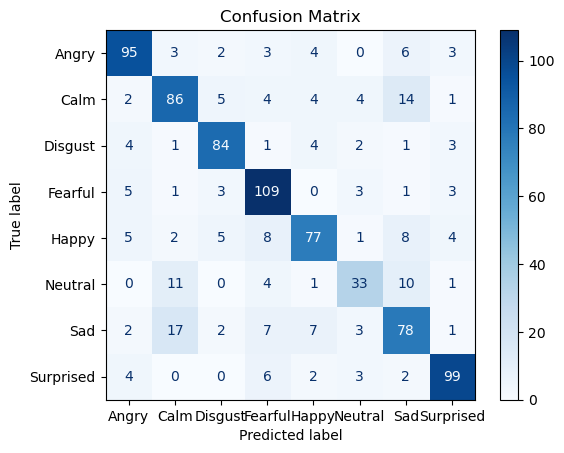

In [12]:
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress specific warnings

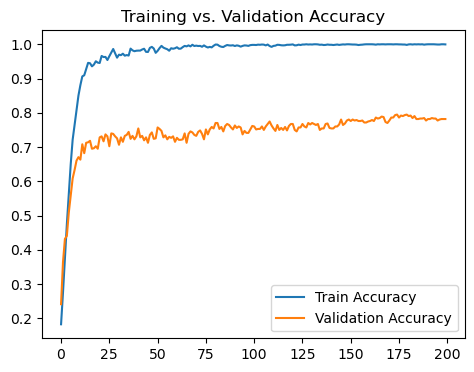

In [14]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.legend()

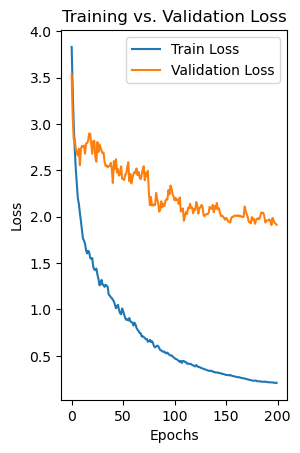

In [15]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [36]:
# Function to preprocess a single input audio file (NEW FUNCTIONALITY)
def preprocess_single_audio(audio_path, sequence_length=143):
    """
    Preprocess a single audio file for emotion prediction.
    Steps:
    - Load the audio
    - Extract MFCC features
    - Normalize and pad/truncate to common sequence length
    """
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(audio_path, duration=3, sr=22050, res_type='kaiser_fast')
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        # Pad or truncate MFCCs to the common sequence length
        if mfcc.shape[1] > sequence_length:
            mfcc = mfcc[:, :sequence_length]
        else:
            mfcc = np.pad(mfcc, ((0, 0), (0, sequence_length - mfcc.shape[1])), mode='constant')
        # Expand dimensions to match model input
        mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension
        return mfcc
    except Exception as e:
        print(f"Error processing the file: {e}")
        return None

# Function to predict emotion from a new audio file (NEW FUNCTIONALITY)
def predict_emotion_from_audio(audio_path):
    """
    Predict emotion from the given audio file.
    """
    # Preprocess the audio
    mfcc_features = preprocess_single_audio(audio_path)
    if mfcc_features is None:
        return "Error in preprocessing the audio file."
    # Predict the emotion
    predictions = model.predict(mfcc_features)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_emotion = label_encoder.inverse_transform([predicted_index])[0]
    return predicted_emotion

# Interactive user input (NEW FUNCTIONALITY)
print("Enter the path to the audio file for emotion prediction:")
file_path = input("Audio file path: ")

# Predict the emotion
predicted_emotion = predict_emotion_from_audio(file_path)
print(f"The predicted emotion for the given audio file is: {predicted_emotion}")


Enter the path to the audio file for emotion prediction:


Audio file path:  C:\Users\PRAJWAL\Downloads\test7.wav


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The predicted emotion for the given audio file is: Angry
